# 深度学习与艺术：神经风格迁移
这一节将要实现神经迁移算法，生成新奇的艺术图片使用自己的算法。大多数的算法已经学习到的都是优化代价函数得到一些参数值，而在神经风格迁移中，将会优化一个代价函数得到像素值。

In [1]:
import os
import sys
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
from nst_utils import *
import numpy as np
import tensorflow as tf

%matplotlib inline

## 1. 问题陈述
神经风格迁移（NST）是深度学习中一种又去的技术。将两张图片融合在一起，C（内容图片），S（风格图片），G（合成图片）
![神经风格迁移](https://upload-images.jianshu.io/upload_images/5355764-c13d404760cc8265.png?imageMogr2/auto-orient/strip%7CimageView2/2/w/1240)


## 2. 迁移学习
NST使用一种已经训练好的网络，这种使用在另一种任务上训练好的网络并把这个网络应用到新的任务上的思想就叫做迁移学习。

我们将使用CGG网络，并且使用的是VGG-19网络，有19层，这个模型在非常大量的图片数据库上已经训练过了，并且学习了很多不同低层次的特征，在浅层的时候，同时在高层也学到了很多高级特征。

In [3]:
# 加载VGG模型的参数
model = load_vgg_model("pretrained-model/imagenet-vgg-verydeep-19.mat")
print(model)

{'avgpool3': <tf.Tensor 'AvgPool_2:0' shape=(1, 38, 50, 256) dtype=float32>, 'conv2_1': <tf.Tensor 'Relu_2:0' shape=(1, 150, 200, 128) dtype=float32>, 'conv3_3': <tf.Tensor 'Relu_6:0' shape=(1, 75, 100, 256) dtype=float32>, 'conv5_3': <tf.Tensor 'Relu_14:0' shape=(1, 19, 25, 512) dtype=float32>, 'conv4_1': <tf.Tensor 'Relu_8:0' shape=(1, 38, 50, 512) dtype=float32>, 'input': <tf.Variable 'Variable:0' shape=(1, 300, 400, 3) dtype=float32_ref>, 'avgpool4': <tf.Tensor 'AvgPool_3:0' shape=(1, 19, 25, 512) dtype=float32>, 'conv5_4': <tf.Tensor 'Relu_15:0' shape=(1, 19, 25, 512) dtype=float32>, 'conv4_2': <tf.Tensor 'Relu_9:0' shape=(1, 38, 50, 512) dtype=float32>, 'conv2_2': <tf.Tensor 'Relu_3:0' shape=(1, 150, 200, 128) dtype=float32>, 'avgpool5': <tf.Tensor 'AvgPool_4:0' shape=(1, 10, 13, 512) dtype=float32>, 'conv4_3': <tf.Tensor 'Relu_10:0' shape=(1, 38, 50, 512) dtype=float32>, 'conv5_2': <tf.Tensor 'Relu_13:0' shape=(1, 19, 25, 512) dtype=float32>, 'conv1_1': <tf.Tensor 'Relu:0' shape

这个模型被存在一个python字典里面，每一个变量名就是一个key，对应的值是一个张量，包含变量的值。为了使一张图片运行在这个网络，喂入这个模型，使用tf。assign函数，实际上，使用函数model["input"].assign(image)。

这个任务使一张图片作为输入输入到模型里。之后，就想要获取某一层的激活值，直接在model字典里，输入参数4_2，就可以获得这一层上的运行结果。
sess.run(model["conv4_2"])


## 3. 神经风格迁移
- Build the content cost function $J_{content}(C,G)$
- Build the style cost function $J_{style}(S,G)$
- Put it together to get $J(G) = \alpha J_{content}(C,G) + \beta J_{style}(S,G)$. 

### 3.1 计算内容代价


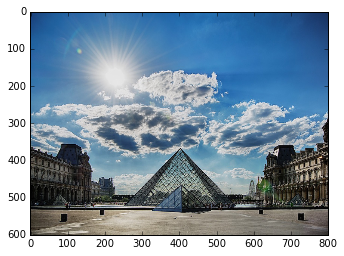

In [4]:
#使用下面代码看一下要进行风格转化的原图什么样子
content_image = scipy.misc.imread("images/louvre.jpg")
imshow(content_image)

#### 3.1.1 如何保证生成的图像G和C原始图像的内容一致呢
卷积网络的浅层试图学习一些低层次的特征比如说边缘或者简单的纹理，后面的比较深的层会学习一些高层次的特征，比如目标对象等。我们想要G和C有一样的内容。加入你选择一些层的激活函数来代表一张图片的内容，实际上，如果你在网络的中间选择一层——既不太浅也不太深，你会得到最赏心悦目的结果。

所以假设你已经选择了某一层，现在，将图片C作为训练好的VGG网络的输入，并且执行前向传播。使用 $a^{(C)}$ 代表选择的隐藏层的激活值，实际上是有上标代表第几层的，但是这里我们省略上标符号简化表示。 $a^{[l](C)}$,  $[l]$ to simplify the notation.)，$a^{(C)}$会是一个$n_H \times n_W \times n_C$的张量。重复这个过程使用图片G，用于正向传播。那么就可以定义内容代价函数了：
$$J_{content}(C,G) =  \frac{1}{4 \times n_H \times n_W \times n_C}\sum _{ \text{all entries}} (a^{(C)} - a^{(G)})^2\tag{1} $$

前面的部分是用来做归一化处理的。为了表达更清楚一点，计算$J_{content}(C,G)$，可能将三维的数据转化为二维的会更方便一点。其实从技术上来说，计算内容代价函数是不需要重整维度的，但是在计算风格代价函数的时候这就会起到作用了。

![关于重整维度，将三维变成二维，也就是把每个过滤器计算的结果平展成一维](https://upload-images.jianshu.io/upload_images/1779926-2a88b7ae8889a922.png?imageMogr2/auto-orient/strip%7CimageView2/2/w/1240)


计算内容代价函数：
1. 从a_G里面获取维度信息，a_G表示的是一个样本的在某一层的激活值
    从一个张量x里面获取维度信息，使用代码：X.get_shape().as_list()
2. 重新整合两个激活值的维度
3. 按公式

In [5]:
# GRADED FUNCTION: compute_content_cost
#计算内容代价

def compute_content_cost(a_C, a_G):
    """
    Computes the content cost
    
    Arguments:
    a_C -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image C 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image G
    
    Returns: 
    J_content -- scalar that you compute using equation 1 above.
    """
    
    ### START CODE HERE ###
    # Retrieve dimensions from a_G (≈1 line)
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    # Reshape a_C and a_G (≈2 lines)
    a_C_unrolled = tf.reshape(a_C,[n_H*n_W,n_C])
    a_G_unrolled = tf.reshape(a_G,[n_H*n_W,n_C])
    
    # compute the cost with tensorflow (≈1 line)
    J_content = tf.reduce_sum(tf.square(tf.subtract(a_C_unrolled,a_G_unrolled)))/(4.0*n_H*n_W*n_C)
    ### END CODE HERE ###
    
    return J_content

In [6]:
tf.reset_default_graph()

with tf.Session() as test:
    tf.set_random_seed(1)
    a_C = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    a_G = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    J_content = compute_content_cost(a_C, a_G)
    print("J_content = " + str(J_content.eval()))

J_content = 6.765593


<font color='blue'>
**What you should remember**:
- The content cost takes a hidden layer activation of the neural network, and measures how different $a^{(C)}$ and $a^{(G)}$ are. 
- When we minimize the content cost later, this will help make sure $G$ has similar content as $C$.

### 3.2 计算风格代价

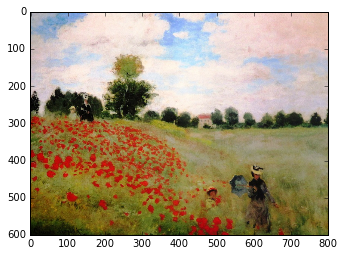

In [7]:
#使用的风格图片，加载展示出来look
style_image = scipy.misc.imread("images/monet_800600.jpg")
imshow(style_image)

#### 3.2.1 风格矩阵
风格矩阵就是“Gram matrix”，在线性代数里面，风格矩阵是向量的点积矩阵，${\displaystyle G_{ij} = v_{i}^T v_{j} = np.dot(v_{i}, v_{j})  }$。换句话说，$G_{ij}$就是用来比较$v_{i}$和$v_{j}$有多相似的。

![关于风格矩阵定义](https://upload-images.jianshu.io/upload_images/1779926-38d2ceb8b6f27dbe.png?imageMogr2/auto-orient/strip%7CimageView2/2/w/1240)

由上图可以看出，关于一个nH*nW*nC的三个通道的激活值的计算，其风格矩阵的计算方法是每个通道之间的内容计算相关系数，相关系数的方法就是两个矩阵之间计算对应元素的乘积的加和，对于一个三维的来说，就是通道间的两两过滤器卷积值进行相关系数计算，组合成一个新的二维矩阵，所以最后是（nC，nC）维度。

并且对于已经将三维的高和宽两个维度展开后，得到二维矩阵，想要计算通道间两两之间的点积，那么就是对这个展开后形成的矩阵，再乘以这个矩阵的转置。

In [14]:
#计算一个三维矩阵的风格矩阵
# GRADED FUNCTION: gram_matrix

def gram_matrix(A):
    """
    Argument:
    A -- matrix of shape (n_C, n_H*n_W)
    
    Returns:
    GA -- Gram matrix of A, of shape (n_C, n_C)
    """
    
    ### START CODE HERE ### (≈1 line)
    GA = tf.matmul(A,tf.transpose(A))
    ### END CODE HERE ###
    
    return GA

In [15]:
tf.reset_default_graph()

with tf.Session() as test:
    tf.set_random_seed(1)
    A = tf.random_normal([3, 2*1], mean=1, stddev=4)
    GA = gram_matrix(A)
    
    print("GA = " + str(GA.eval()))

GA = [[ 6.422305 -4.429122 -2.096682]
 [-4.429122 19.465837 19.563871]
 [-2.096682 19.563871 20.686462]]


#### 3.2.2 风格代价
生成风格矩阵后，目标就是最小化S和G的风格矩阵距离。同样的，只使用某一层的激活函数值，那么相关代价函数的公式就是：
$$J_{style}^{[l]}(S,G) = \frac{1}{4 \times {n_C}^2 \times (n_H \times n_W)^2} \sum _{i=1}^{n_C}\sum_{j=1}^{n_C}(G^{(S)}_{ij} - G^{(G)}_{ij})^2\tag{2} $$

练习：对某一个单层实现计算代价函数:3个步骤如下：
1. 从隐藏单元某一层的tensor张量中获取维度信息，使用代码如：X.get_shape().as_list()
2. 将得到的激活函数三维值变成二维的
3. 计算S和G的风格矩阵
4. 计算风格代价

In [18]:
# GRADED FUNCTION: compute_layer_style_cost

def compute_layer_style_cost(a_S, a_G):
    """
    Arguments:
    a_S -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image S 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image G
    
    Returns: 
    J_style_layer -- tensor representing a scalar value, style cost defined above by equation (2)
    """
    
    ### START CODE HERE ###
    # Retrieve dimensions from a_G (≈1 line)
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    # Reshape the images to have them of shape (n_H*n_W, n_C) (≈2 lines)
    a_S = tf.reshape(a_S,[n_H*n_W,n_C])
    a_G = tf.reshape(a_G,[n_H*n_W,n_C])

    # Computing gram_matrices for both images S and G (≈2 lines)
    GS =  gram_matrix(tf.transpose(a_S))
    GG = gram_matrix(tf.transpose(a_G))

    # Computing the loss (≈1 line)
    J_style_layer = tf.reduce_sum(tf.square(tf.subtract(GS,GG)))/(4.0*(n_C*n_C)*(n_H*n_W)*(n_H*n_W))
    
    ### END CODE HERE ###
    
    return J_style_layer

In [19]:
tf.reset_default_graph()

with tf.Session() as test:
    tf.set_random_seed(1)
    a_S = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    a_G = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    J_style_layer = compute_layer_style_cost(a_S, a_G)
    
    print("J_style_layer = " + str(J_style_layer.eval()))

J_style_layer = 9.190278


#### 3.2.3 风格权重
上面计算代价函数是关于某一层的，如果我们把很多不同的层的代价函数都计算在一起，那么会得到更好的结果。

In [20]:
# 关于每一层的λ值，调整每一层占的比重
STYLE_LAYERS = [
    ('conv1_1', 0.2),
    ('conv2_1', 0.2),
    ('conv3_1', 0.2),
    ('conv4_1', 0.2),
    ('conv5_1', 0.2)]

计算不同的层的代价函数总和公式为：
$$J_{style}(S,G) = \sum_{l} \lambda^{[l]} J^{[l]}_{style}(S,G)$$

$lambda^{[l]}$ 表示在STYLE_LAYERS里。接下里计算所有层的风格代价总和，会调用到上面实现的每一层风格代价计算方法函数很多次。

In [21]:
def compute_style_cost(model, STYLE_LAYERS):
    """
    Computes the overall style cost from several chosen layers
    
    Arguments:
    model -- our tensorflow model
    STYLE_LAYERS -- A python list containing:
                        - the names of the layers we would like to extract style from
                        - a coefficient for each of them
    
    Returns: 
    J_style -- tensor representing a scalar value, style cost defined above by equation (2)
    """
    
    # 初始化整体代价函数值
    J_style = 0

    for layer_name, coeff in STYLE_LAYERS:

        # 从当前选中的层里得到输出的张量Select the output tensor of the currently selected layer
        out = model[layer_name]

        # Set a_S to be the hidden layer activation from the layer we have selected, by running the session on out
        a_S = sess.run(out)

        # Set a_G to be the hidden layer activation from same layer. Here, a_G references model[layer_name] 
        # and isn't evaluated yet. Later in the code, we'll assign the image G as the model input, so that
        # when we run the session, this will be the activations drawn from the appropriate layer, with G as input.
        a_G = out
        
        # Compute style_cost for the current layer
        J_style_layer = compute_layer_style_cost(a_S, a_G)

        # Add coeff * J_style_layer of this layer to overall style cost
        J_style += coeff * J_style_layer

    return J_style

在这个内部循环里面，a_G是个张量还没有被计算，它会在每次运行model_nn() 时，在tensorflow计算图中计算和被更新。而a_S是一个固定的量，所以就直接用sess.run(out)得到计算结果。

<font color='blue'>
**What you should remember**:
- The style of an image can be represented using the Gram matrix of a hidden layer's activations. However, we get even better results combining this representation from multiple different layers. This is in contrast to the content representation, where usually using just a single hidden layer is sufficient.
- Minimizing the style cost will cause the image $G$ to follow the style of the image $S$. 
</font color='blue'>


### 3.3 定义需要优化的总代价函数
$$J(G) = \alpha J_{content}(C,G) + \beta J_{style}(S,G)$$

In [22]:
# GRADED FUNCTION: total_cost

def total_cost(J_content, J_style, alpha = 10, beta = 40):
    """
    Computes the total cost function
    
    Arguments:
    J_content -- content cost coded above
    J_style -- style cost coded above
    alpha -- hyperparameter weighting the importance of the content cost
    beta -- hyperparameter weighting the importance of the style cost
    
    Returns:
    J -- total cost as defined by the formula above.
    """
    
    ### START CODE HERE ### (≈1 line)
    J = alpha*J_content+beta*J_style
    ### END CODE HERE ###
    
    return J

In [23]:
tf.reset_default_graph()

with tf.Session() as test:
    np.random.seed(3)
    J_content = np.random.randn()    
    J_style = np.random.randn()
    J = total_cost(J_content, J_style)
    print("J = " + str(J))

J = 35.34667875478276


<font color='blue'>
**What you should remember**:
- The total cost is a linear combination of the content cost $J_{content}(C,G)$ and the style cost $J_{style}(S,G)$
- $\alpha$ and $\beta$ are hyperparameters that control the relative weighting between content and style

### 4. 解决优化问题
接下来我们把视线身神经风格迁移的所有东西整合起来：
1. 创建一个交互的session
2. 加载内容图片
3. 加载风格图片
4. 随机初始化G的像素
5. 加载VGG16模型
6. 建立tensorflow计算图
    - 在VGG16模型上运行内容图片，并且计算内容代价
    - 在VGG16模型上运行风格图片，并且计算风格代价
    - 计算总的代价
    - 定义优化器以及学习率
7. 初始化tensorflow计算图，并且运行它迭代很多次，每一步都需要更新生成图片G的像素

已经实现好全局代价J（G）了，所以接下来建立关于G的tensorflow优化器。为了达到这个目的，程序必须重置计算图并且使用一个interactive session。不像一般的session，这个交互session初始化自身，作为默认的session并且建立计算图。这个操作允许你运行变量而不需要经常引用会话对象，从而简化了代码。

In [25]:
# Reset the graph
tf.reset_default_graph()

# Start interactive session
sess = tf.InteractiveSession()

In [3]:
# 加载，reshape，归一化内容图片：
content_image = scipy.misc.imread("images/louvre_small.jpg")
print(content_image.shape)
content_image = reshape_and_normalize_image(content_image)
print(content_image.shape)

(300, 400, 3)
(1, 300, 400, 3)


In [5]:
#加载风格图片
style_image = scipy.misc.imread("images/monet.jpg")
print(style_image.shape)
style_image = reshape_and_normalize_image(style_image)
print(style_image.shape)

(300, 400, 3)
(1, 300, 400, 3)


现在初始化这个G图片从内容图片得到一个噪点图片，通过初始化G为一个跟内容图片比较相关的但是有很多噪点的图，可以帮助生成的G的内容可以快速的和C内容图片的内容匹配。这个函数已经写好了在nst.utils这个文件里面。

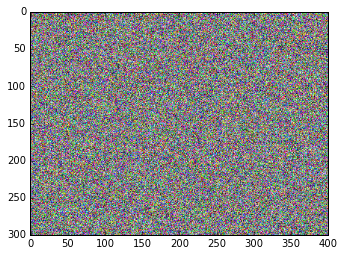

In [27]:
generated_image = generate_noise_image(content_image)
imshow(generated_image[0])

In [28]:
#加载VGG16模型
model = load_vgg_model("pretrained-model/imagenet-vgg-verydeep-19.mat")

为了让程序计算内容函数，我们需要assigna_C和a_G为合适的隐藏层激活值，我们将会使用conv4_2这一层的值来计算。那么接下来就要做下面这些事：
1. 将内容图片设置为VGG模型的输入
2. 设置a_C为conv4_2隐藏层激活张量
3. 设置a_G为相同的隐藏层的激活值张量
4. 计算内容函数使用a_C和a_G

In [29]:
# 1.将内容图片设置为VGG模型的输入 
sess.run(model['input'].assign(content_image))

# Select the output tensor of layer conv4_2
out = model['conv4_2']

# Set a_C to be the hidden layer activation from the layer we have selected
a_C = sess.run(out)

# Set a_G to be the hidden layer activation from same layer. Here, a_G references model['conv4_2'] 
# and isn't evaluated yet. Later in the code, we'll assign the image G as the model input, so that
# when we run the session, this will be the activations drawn from the appropriate layer, with G as input.
a_G = out

# Compute the content cost
J_content = compute_content_cost(a_C, a_G)

In [32]:
# 将风格图片设置为VGG模型的输入 
sess.run(model['input'].assign(style_image))

# 计算风格代价，其中也是和风格计算一样，关于a_C和a_S都是已经sess.run之后的
#但是关于G则是需要在每次迭代的时候才计算的，代价里面需要计算每一层的代价值，所以
#就写在了计算总风格代价函数的内部
J_style = compute_style_cost(model, STYLE_LAYERS)

In [33]:
# 接下来定义总代价函数，使用 alpha = 10 and beta = 40
J = total_cost(J_content, J_style, alpha = 10, beta = 40)

In [34]:
# define optimizer (1 line)
optimizer = tf.train.AdamOptimizer(2.0)

# define train_step (1 line)
train_step = optimizer.minimize(J)

In [35]:
#实现下面这个model_nn模型，初始化计算图的变量，分配输入图片（包括初始化G），并且执行train_step，使用比较大的步

def model_nn(sess, input_image, num_iterations = 200):
    
    # Initialize global variables (you need to run the session on the initializer)
    ### START CODE HERE ### (1 line)
    sess.run(tf.global_variables_initializer())
    ### END CODE HERE ###
    
    # Run the noisy input image (initial generated image) through the model. Use assign().
    ### START CODE HERE ### (1 line)
    generated_image=sess.run(model['input'].assign(input_image))
    ### END CODE HERE ###
    
    for i in range(num_iterations):
    
        # Run the session on the train_step to minimize the total cost
        ### START CODE HERE ### (1 line)
        sess.run(train_step)
        ### END CODE HERE ###
        
        # Compute the generated image by running the session on the current model['input']
        ### START CODE HERE ### (1 line)
        generated_image = sess.run(model['input'])
        ### END CODE HERE ###

        # Print every 20 iteration.
        if i%20 == 0:
            Jt, Jc, Js = sess.run([J, J_content, J_style])
            print("Iteration " + str(i) + " :")
            print("total cost = " + str(Jt))
            print("content cost = " + str(Jc))
            print("style cost = " + str(Js))
            
            # save current generated image in the "/output" directory
            save_image("output/" + str(i) + ".png", generated_image)
    
    # save last generated image
    save_image('output/generated_image.jpg', generated_image)
    
    return generated_image

接下来就可以调用模型，并且生成风格融合的艺术图了，在CPU上每20次迭代可能会话三分钟，但是在大约140次迭代之后，就能看到很好的效果了。神经风格迁移通常都使用GPU来训练。

In [36]:
model_nn(sess, generated_image)

Iteration 0 :
total cost = 5050405000.0
content cost = 7877.603
style cost = 126258140.0
Iteration 20 :
total cost = 943255740.0
content cost = 15186.917
style cost = 23577596.0
Iteration 40 :
total cost = 484914750.0
content cost = 16782.408
style cost = 12118673.0
Iteration 60 :
total cost = 312579170.0
content cost = 17462.844
style cost = 7810114.0
Iteration 80 :
total cost = 228124430.0
content cost = 17713.928
style cost = 5698682.5
Iteration 100 :
total cost = 180644750.0
content cost = 17891.242
style cost = 4511646.0
Iteration 120 :
total cost = 149872640.0
content cost = 18038.252
style cost = 3742306.5
Iteration 140 :
total cost = 127638810.0
content cost = 18181.617
style cost = 3186424.8
Iteration 160 :
total cost = 110592860.0
content cost = 18346.207
style cost = 2760235.0
Iteration 180 :
total cost = 97253620.0
content cost = 18488.754
style cost = 2426718.2


array([[[[ -47.79587  ,  -61.17298  ,   48.589718 ],
         [ -26.224579 ,  -40.40081  ,   27.020405 ],
         [ -41.92992  ,  -28.918764 ,   11.165789 ],
         ...,
         [ -26.490255 ,   -9.256703 ,   14.320422 ],
         [ -29.817501 ,   -2.7739668,   24.063875 ],
         [ -41.48793  ,   -3.6370344,   49.78128  ]],

        [[ -61.38783  ,  -51.713326 ,   25.085386 ],
         [ -33.146984 ,  -31.028788 ,   -1.5170385],
         [ -27.267878 ,  -30.6542   ,   15.110093 ],
         ...,
         [ -26.64399  ,   -5.1685677,   25.63365  ],
         [ -21.347422 ,  -17.295645 ,   13.400611 ],
         [ -40.39159  ,   -6.4714365,    9.311003 ]],

        [[ -52.54654  ,  -51.67363  ,   13.327145 ],
         [ -37.32582  ,  -41.466404 ,   -6.3660464],
         [ -34.334576 ,  -25.28246  ,    7.2349205],
         ...,
         [ -10.748886 ,  -37.462967 ,   12.353677 ],
         [ -12.41184  ,  -21.31605  ,   16.889801 ],
         [ -22.659746 ,  -18.93269  ,   13.976666 ]],

我们不想让你等太久，而只看到一个初步的结果，所以设置了相应的参数。为了获得最好的结果，优化算法的运行时间更长（也许学习速率更小）可能会更好。在完成和提交这项任务后，我们鼓励你回来，多玩这个笔记本，看看你是否能生成更好看的图像。


## 5. 使用你自己的图片进行测
要求图片是（255\*300），并且修改喂入的C和S的图片。
重新运行这个notebook里的代码，也可以重启kernel

你也可以调整超参数，哪一层能更好的代表风格呢？在STYLE_LAYERS里可以修改不同层占的比重，运行算法需要迭代多少次呢？numitrations，关于风格代价和内容代价应该如何设置相对的占比呢？alpha/beta

## 6. 总结
现在你已经可以使用神经风格迁移来生成艺术图了，并且也是第一次建立模型来优化算法的输入内容的像素值而不再是超参数，深度学习有很多的模型，这只是其中的一种。

<font color='blue'>
What you should remember:
- Neural Style Transfer is an algorithm that given a content image C and a style image S can generate an artistic image
- It uses representations (hidden layer activations) based on a pretrained ConvNet. 
- The content cost function is computed using one hidden layer's activations.
- The style cost function for one layer is computed using the Gram matrix of that layer's activations. The overall style cost function is obtained using several hidden layers.
- Optimizing the total cost function results in synthesizing new images.